## 分析聯合新聞網總統大選期間相關新聞之詞彙關係

我們組使用聯合新聞網 全球(global)、社會(social)、產經(produce)、股市(stock) 四個版的資料，並使用TF-IDF, N-gram等方法找出文章以及字詞間的關聯。 

## 1. 載入套件

In [1]:
# ％pip install -U networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [4]:
# cloab 字體設定
import matplotlib
# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('./taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集聯合新聞網文章
+ 時間: 2023-12-13 ~ 2024-01-13 (總統大選前一個月期間)
+ 選擇版別: 全球(global)、社會(social)、財經 (由產經、股市版合併)
+ 資料筆數：共 8802 則新聞

In [5]:
#匯入資料
df = pd.read_csv('./raw_data/聯合新聞_merge.csv', encoding = 'UTF-8')
df

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,NaN,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,UDN
1,1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,NaN,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，...,UDN
2,2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,NaN,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前...,UDN
3,3,4,烏克蘭再傳軍購弊案！國防高官涉盜4千萬美元 恐面臨15年刑期,2023-12-24 08:53:00,全球,NaN,https://udn.com/news/story/122663/7661805,"紐約時報報導，當地時間22日，烏克蘭一名高級國防官員涉嫌中飽私囊，盜用軍購案近4,000萬美...",UDN
4,4,5,紐時：普亭透過秘密外交管道釋出和談訊息 願就目前戰線停火,2023-12-24 12:07:00,全球,NaN,https://udn.com/news/story/122663/7662087,紐約時報報導，俄羅斯總統普亭日前在公開場合堅定表示俄烏戰爭打到底，不過就知情的俄國前官員及美...,UDN
...,...,...,...,...,...,...,...,...,...
8797,8798,8799,長榮、陽明 四檔閃金光,2024-01-12 23:40:00,財經,https://udn.com/news/story/7255/7704877,紅海危機不斷升溫，造成上海集裝箱出口（SCFI）運價指數周漲幅16.31%，四大航線全面大漲...,NaN,UDN
8798,8799,8800,全民權證／力成 押價內外10%,2024-01-12 23:38:00,財經,https://udn.com/news/story/7255/7704879,力成（6239）去年第4季營運由於DRAM、NAND Flash及Logic等急單挹注情況優...,NaN,UDN
8799,8800,8801,全民權證／大立光 選逾120天,2024-01-12 23:37:00,財經,https://udn.com/news/story/7255/7704881,大立光（3008）2023年營收488.42億元，年增2%，連兩年回溫；稅後純益179.08...,NaN,UDN
8800,8801,8802,最牛一輪／文曄出運 群益34叫好,2024-01-12 23:35:00,財經,https://udn.com/news/story/7255/7704882,"文曄（3036）去年第4季合併營收約新台幣1,897億元，季增13%，年增20%，創單季新高...",NaN,UDN


In [6]:
#查看各版筆數分佈
df.groupby('artCatagory').size()

artCatagory
全球    2570
社會    1817
財經    4415
dtype: int64

### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [7]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['dataSource','artSecondCatagory'], axis=1)
MetaData['artContent'] = MetaData['artContent'].astype(str)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...
1,1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，...,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄...
2,2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前...,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交...


### 2.3 文章斷詞與整理

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [10]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from /Users/tsaipingyu/Downloads/study_udn/week6/dict/dict.txt.big ...
Dumping model to file cache /var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/jieba.ubf6be4b4cdf1070e43918726c2be498a.cache
Loading model cost 0.481 seconds.
Prefix dict has been built successfully.


,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭
1,1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，...,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄...,新任
2,2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前...,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交...,外交部長


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 3.1 應用於資料集（套件）

In [11]:
udn_df = MetaData.copy()
udn_df.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...
1,1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，...,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄...
2,2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前...,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交...


In [12]:
# 保留需要的欄位
udn_df = udn_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
udn_df['word'] = udn_df.sentence.apply(getToken).map(' '.join)

udn_df.head()

,system_id,sentence,word
0,1,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任 外交部長 科斯 敦促 西方 團結 力挺 烏克蘭 選擇 飽受 戰爭 蹂躪 國家 外...
1,2,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄...,美國白宮 聲明 總統 拜登 簽署 行政命令 將對 支持 俄羅斯 攻打 烏克蘭 外國 銀行 制...
2,3,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交...,烏克蘭 總統 倫斯基 軍方 官員 南部 前線 擊落 俄羅斯 蘇愷 轟炸機 稱讚 這是 交戰 ...
3,4,紐約時報報導當地時間日烏克蘭一名高級國防官員涉嫌中飽私囊盜用軍購案近萬美元目前已遭撤職逮捕查...,紐約時報 時間 烏克蘭 一名 高級 國防 官員 涉嫌 中飽私囊 盜用 軍購案 萬美元 撤職 ...
4,5,紐約時報報導俄羅斯總統普亭日前在公開場合堅定表示俄烏戰爭打到底不過就知情的俄國前官員及美國官...,紐約時報 俄羅斯 總統 普亭 日前 公開場合 堅定 俄烏 戰爭 知情 俄國 官員 美國 官員...


In [13]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(udn_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一七,一三二,一三五,一三輝,一下下,一下子,一中,一串,一九,...,龐德,龐畢度,龐雜,龔明鑫,龔明鑫還,龔薩福以,龔薩雷茲,龜山,龜澤,龜裂
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

#TFIDF_df

### 3.2 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [15]:
udn_tfidf = TFIDF_df.mean().to_frame().reset_index()
udn_tfidf.columns = ["word", "avg"]

udn_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
19623,市場,0.005934
41206,美國,0.005646
11607,台灣,0.005600
7198,公司,0.005572
27119,明年,0.005548
6028,億元,0.005468
23620,投資,0.005386
6859,全球,0.004705
3991,以色列,0.004256
51786,銀行,0.004144


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [16]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一七,一三二,一三五,一三輝,一下下,一下子,一中,一串,...,龐德,龐畢度,龐雜,龔明鑫,龔明鑫還,龔薩福以,龔薩雷茲,龜山,龜澤,龜裂
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8797,8798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8798,8799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,8800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8800,8801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
494153077,8798,龜裂,0.0
494153078,8799,龜裂,0.0
494153079,8800,龜裂,0.0
494153080,8801,龜裂,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [18]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

/var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/ipykernel_3423/3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
0,一一,5930
2,一三二,5929
3,一三五,5929
4,一三輝,5929
5,一下下,5929
6,一下子,5929
7,一中,5929
8,一串,5929
9,一九,5929
1,一七,5929


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### 4.1 Bigram

In [19]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [20]:
udn_bigram = MetaData.copy()

udn_bigram["word"] = udn_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
udn_bigram = udn_bigram.explode('word')

udn_bigram.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,新任 外交部長
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,外交部長 科斯


#### 統計最常出現的bigram組合

In [21]:
# 計算每個組合出現的次數
udn_bigram_count = udn_bigram['word'].value_counts().reset_index()

udn_bigram_count.sort_values('count', ascending=False).head(20)

,word,count
0,實支 實付,927
1,平面 車位,549
2,公告 土地,440
3,土地 現值,382
4,月餘 房價,282
5,部落 客中,282
6,永和 安身立命,282
7,安身立命 看屋,282
8,客中 永和,282
9,房價 灰心,282


### 4.2 Trigram

In [22]:
udn_trigram = MetaData.copy()

udn_trigram["word"] = udn_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
udn_trigram = udn_trigram.explode('word')

udn_trigram.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任 外交部長
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,新任 外交部長 科斯
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,外交部長 科斯 敦促


#### 統計最常出現的trigram組合

In [23]:
# 計算每個組合出現的次數
udn_trigram_count = udn_trigram['word'].value_counts().reset_index()

udn_trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,公告 土地 現值,382
1,永和 安身立命 看屋,282
2,灰心 轉戰 桃園,282
3,房價 灰心 轉戰,282
4,月餘 房價 灰心,282
5,看屋 月餘 房價,282
6,安身立命 看屋 月餘,282
7,部落 客中 永和,282
8,客中 永和 安身立命,282
9,平面 車位 建案,273


從上面的 bigram 和 trigram 的結果中，我們把常一起出現的詞彙加入自訂義辭典 "lexicon" 中。  
我們加入了: 實支實付、平面車位、部落客、長榮航空......等。

### 4.3 使用自建字典

In [24]:
# 新增自定義字典
jieba.load_userdict('./dict/lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [25]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,新任
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,外交部長


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [26]:
bigramudist = MetaData.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')

bigramudist.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,新任 外交部長
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,外交部長 科斯


In [27]:
#去除bigramudist["word"]內容為空值的筆數
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)

In [28]:
# 計算每個組合出現的次數
udn_bigram_count = bigramudist['word'].value_counts().reset_index()

udn_bigram_count.sort_values('count', ascending=False).head(20)

,word,count
0,公告 土地,440
1,土地 現值,382
2,永和 安身立命,282
3,轉戰 桃園,282
4,部落客 永和,282
5,安身立命 看屋,282
6,看屋 月餘,282
7,月餘 房價,282
8,房價 灰心,282
9,灰心 轉戰,282


In [29]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('公告', '土地'), 440),
 (('土地', '現值'), 382),
 (('部落客', '永和'), 282),
 (('永和', '安身立命'), 282),
 (('安身立命', '看屋'), 282)]

In [30]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('公告', '土地'), 440), (('土地', '現值'), 382), (('部落客', '永和'), 282), (('永和', '安身立命'), 282), (('安身立命', '看屋'), 282), (('看屋', '月餘'), 282), (('月餘', '房價'), 282), (('房價', '灰心'), 282), (('灰心', '轉戰'), 282), (('轉戰', '桃園'), 282), (('平面車位', '建案'), 273), (('萬元', '店面'), 261), (('北市', '平面車位'), 259), (('增倍', '專家'), 258), (('最糟', '時間'), 258), (('平面車位', '桃園'), 258), (('商圈', '最快'), 257), (('最快', '復甦'), 257), (('復甦', '店租'), 257), (('店租', '萬元'), 257), (('店面', '增倍'), 257), (('專家', '最糟'), 257), (('時間', '北市'), 257), (('建案', '跌破'), 257), (('跌破', '平面車位'), 257), (('實支實付', '醫療險'), 228), (('新台幣', '匯率'), 224), (('實支實付', '改革'), 193), (('新聞', '追蹤'), 190), (('追蹤', '科技'), 190), (('科技', '玩家'), 190), (('玩家', '好文'), 190), (('好文', '漏接'), 190), (('二手', '蘋果'), 190), (('蘋果', '達人'), 190), (('達人', '曝點'), 190), (('曝點', '檢查項目'), 190), (('高雄', '社宅'), 182), (('買氣', '熱絡'), 179), (('現值', '公告地價'), 179), (('社宅', '戶數'), 179), (('公司', '協商'), 177), (('戶數', '全台'), 177), (('改革', '實支實付'), 177), (('基泰', '首批'), 176), (('首批', '退戶'), 176

In [31]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

公告
440
土地
382
部落客
282
永和
282
安身立命
282
看屋
282
月餘
282
房價
282
灰心
282
轉戰
282
平面車位
273
萬元
261
北市
259
增倍
258
最糟
258
平面車位
258
商圈
257
最快
257
復甦
257
店租
257
店面
257
專家
257
時間
257
建案
257
跌破
257
實支實付
228
新台幣
224
實支實付
193
新聞
190
追蹤
190
科技
190
玩家
190
好文
190
二手
190
蘋果
190
達人
190
曝點
190
高雄
182
買氣
179
現值
179
社宅
179
公司
177
戶數
177
改革
177
基泰
176
首批
176
退戶
176
高達
176
四分之一
176
協商
176


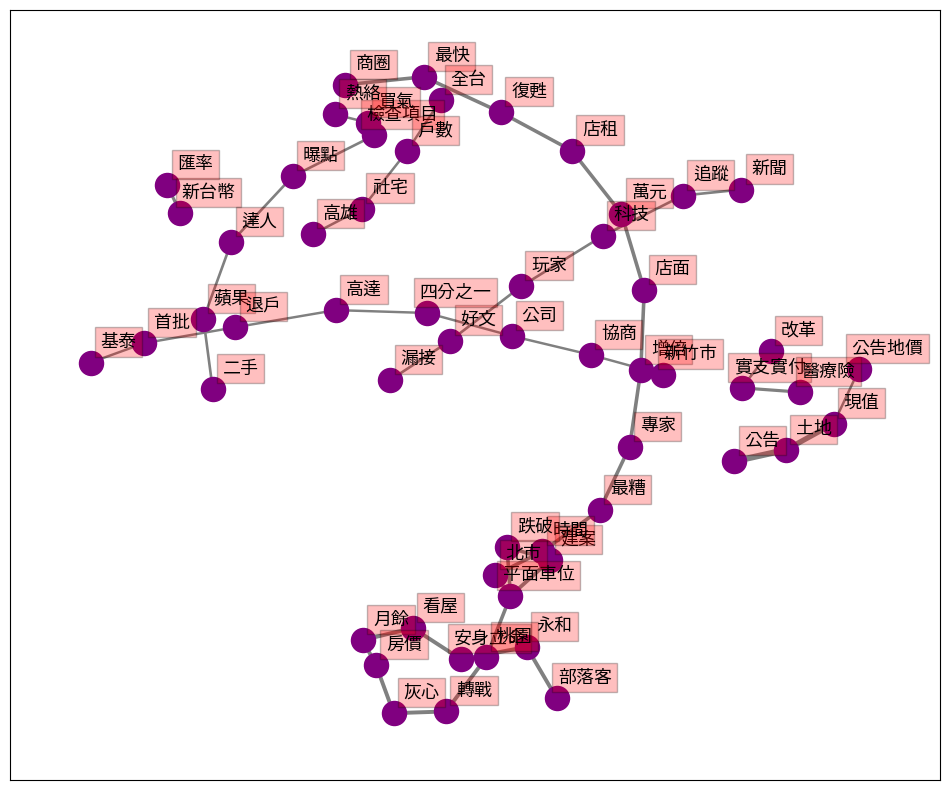

In [32]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

**發現**  
+ 文本中有一些常見的新聞主題，特別是台灣的房地產市場。經過檢視發現，本資料集有4415筆資料是和財經相關的，此圖結果與原始資料集結果吻合。  

+ 文本中各個分群代表這些相關詞彙時常被提及。如上圖可以看出有關於 房地產、醫療險、新台幣匯率、蘋果 相關的主題。

+ 節點間的連線粗細代表兩個詞彙的相關性。例如: 土地公告、土地現值等，代表它們在文本中很常被一起使用。 



### 4.5 Trigram視覺化

更新斷詞字典後重新進行Trigram斷詞

In [33]:
trigramudist = MetaData.copy()

trigramudist["word"] = trigramudist['sentence'].apply(lambda row: ngram_getToken(row, 3))
trigramudist = trigramudist.explode('word')

trigramudist.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任 外交部長
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,新任 外交部長 科斯
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,外交部長 科斯 敦促


In [34]:
#去除trigramudist["word"]內容為空值的筆數
trigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)

In [35]:
# 計算每個組合出現的次數
udn_trigram_count = trigramudist['word'].value_counts().reset_index()

udn_trigram_count.sort_values('count', ascending=False).head(20)

,word,count
0,公告 土地 現值,382
2,月餘 房價 灰心,282
3,部落客 永和 安身立命,282
4,永和 安身立命 看屋,282
5,安身立命 看屋 月餘,282
6,灰心 轉戰 桃園,282
7,房價 灰心 轉戰,282
1,看屋 月餘 房價,282
8,北市 平面車位 建案,259
16,專家 最糟 時間,257


In [36]:
trigramudist['word'] = trigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
trigramudist = FreqDist(trigramudist['word'].apply(lambda x: tuple(x.split(' '))))
trigramudist.most_common(5)

[(('公告', '土地', '現值'), 382),
 (('部落客', '永和', '安身立命'), 282),
 (('永和', '安身立命', '看屋'), 282),
 (('安身立命', '看屋', '月餘'), 282),
 (('看屋', '月餘', '房價'), 282)]

In [37]:
d = {k:v for k,v in trigramudist.most_common(50)}
d.items()

dict_items([(('公告', '土地', '現值'), 382), (('部落客', '永和', '安身立命'), 282), (('永和', '安身立命', '看屋'), 282), (('安身立命', '看屋', '月餘'), 282), (('看屋', '月餘', '房價'), 282), (('月餘', '房價', '灰心'), 282), (('房價', '灰心', '轉戰'), 282), (('灰心', '轉戰', '桃園'), 282), (('北市', '平面車位', '建案'), 259), (('商圈', '最快', '復甦'), 257), (('最快', '復甦', '店租'), 257), (('復甦', '店租', '萬元'), 257), (('店租', '萬元', '店面'), 257), (('萬元', '店面', '增倍'), 257), (('店面', '增倍', '專家'), 257), (('增倍', '專家', '最糟'), 257), (('專家', '最糟', '時間'), 257), (('最糟', '時間', '北市'), 257), (('時間', '北市', '平面車位'), 257), (('平面車位', '建案', '跌破'), 257), (('建案', '跌破', '平面車位'), 257), (('跌破', '平面車位', '桃園'), 257), (('新聞', '追蹤', '科技'), 190), (('追蹤', '科技', '玩家'), 190), (('科技', '玩家', '好文'), 190), (('玩家', '好文', '漏接'), 190), (('二手', '蘋果', '達人'), 190), (('蘋果', '達人', '曝點'), 190), (('達人', '曝點', '檢查項目'), 190), (('土地', '現值', '公告地價'), 179), (('高雄', '社宅', '戶數'), 179), (('社宅', '戶數', '全台'), 177), (('基泰', '首批', '退戶'), 176), (('首批', '退戶', '高達'), 176), (('退戶', '高達', '四分之一'), 176), (('高達', '四分之一', '公司'

In [38]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) 
    G.add_edge(k[0], k[2], weight=v) 
    G.add_edge(k[1], k[2], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

公告
382
部落客
282
永和
282
安身立命
282
看屋
282
月餘
282
房價
282
灰心
282
北市
259
商圈
257
最快
257
復甦
257
店租
257
萬元
257
店面
257
增倍
257
專家
257
最糟
257
時間
257
平面車位
257
建案
257
跌破
257
新聞
190
追蹤
190
科技
190
玩家
190
二手
190
蘋果
190
達人
190
土地
179
高雄
179
社宅
177
基泰
176
首批
176
退戶
176
高達
176
四分之一
176
公司
176
協商
176
新竹市
176
現值
176
公告地價
176
出爐
176
新地
176
戶數
176
全台
176
居冠
176
陳其邁
176
自豪
176
台北
176


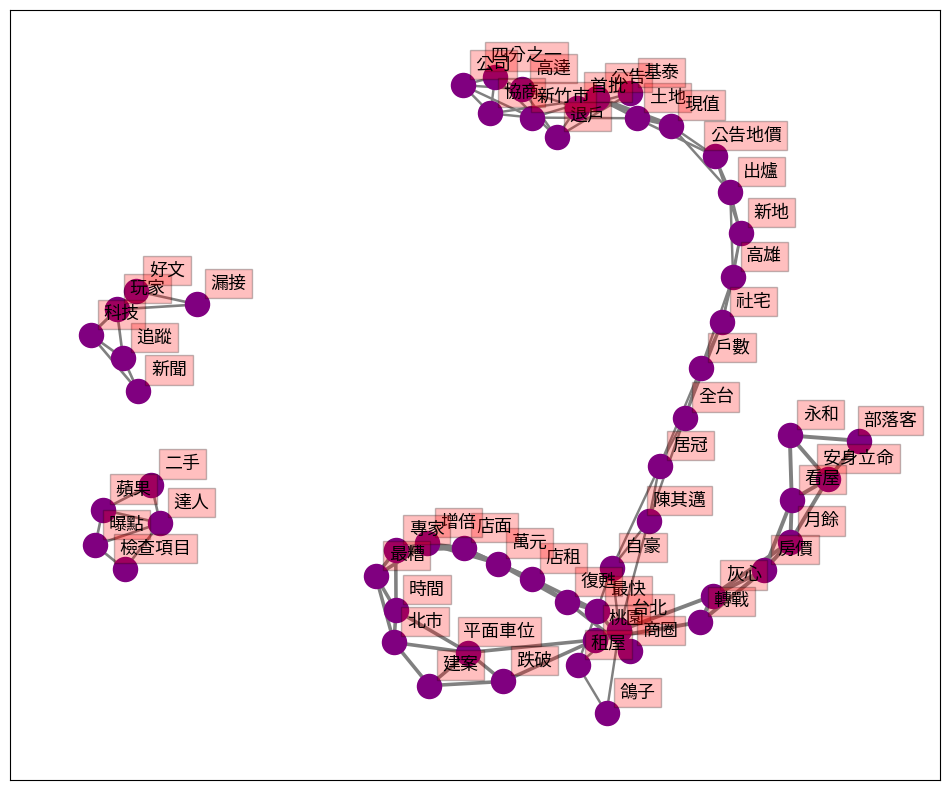

In [39]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

**發現**
+ Trigram 較 Bigram 可以更加清楚地看出詞彙間的上下文關係，幫助我們更好理解文章的主題與重點。

## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [40]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任 外交部長 科斯 敦促 西方 團結 力挺 烏克蘭 選擇 飽受 戰爭 蹂躪 國家 外...
1,1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，...,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄...,美國白宮 聲明 總統 拜登 簽署 行政命令 將對 支持 俄羅斯 攻打 烏克蘭 外國 銀行 制...
2,2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前...,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交...,烏克蘭 總統 倫斯基 軍方 官員 南部 前線 擊落 俄羅斯 蘇愷 轟炸機 稱讚 這是 交戰 ...


In [41]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一名,一年,三峽,上市,上漲,下跌,中國,中心,事件,交易,...,電子,需求,預估,預期,預計,顯示,風險,高達,高雄,龍頭
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一名,一年,三峽,上市,上漲,下跌,中國,中心,事件,...,電子,需求,預估,預期,預計,顯示,風險,高達,高雄,龍頭
0,一名,1.000000,0.016923,-0.015397,-0.017895,-0.013760,-0.009506,0.065400,0.037422,0.238114,...,-0.008189,-0.010492,0.011457,-0.014006,0.102177,0.159654,0.016981,0.029054,-0.005119,-0.021152
1,一年,0.016923,1.000000,0.013176,0.089874,0.190436,0.122438,0.035263,0.073974,0.024373,...,0.058833,0.149229,0.166605,0.180959,0.144091,0.179660,0.092892,0.235718,0.146456,0.216285
2,三峽,-0.015397,0.013176,1.000000,0.011226,0.027792,0.013333,0.011355,0.121232,-0.000956,...,0.146215,0.187019,0.085461,0.129363,0.116833,0.046493,0.034149,0.002696,0.228260,0.302561
3,上市,-0.017895,0.089874,0.011226,1.000000,0.112958,0.072979,0.026370,0.087308,-0.015086,...,0.142953,0.089730,0.201333,0.078589,0.114944,0.081478,0.074195,0.108772,0.019609,0.221414
4,上漲,-0.013760,0.190436,0.027792,0.112958,1.000000,0.407347,0.017543,0.004613,0.007915,...,0.157680,0.092391,0.073787,0.180446,0.072297,0.125715,0.098720,0.120637,0.037423,0.015958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,顯示,0.159654,0.179660,0.046493,0.081478,0.125715,0.124401,0.103944,0.122170,0.141013,...,0.066200,0.163476,0.156135,0.261261,0.174496,1.000000,0.172893,0.192726,0.061568,0.081400
296,風險,0.016981,0.092892,0.034149,0.074195,0.098720,0.138726,0.062117,0.085985,0.035403,...,0.054592,0.065751,0.089928,0.208506,0.077076,0.172893,1.000000,0.124886,0.027884,0.027330
297,高達,0.029054,0.235718,0.002696,0.108772,0.120637,0.068353,0.045053,0.098268,0.036553,...,0.083871,0.142640,0.129630,0.152715,0.176094,0.192726,0.124886,1.000000,0.279182,0.088909
298,高雄,-0.005119,0.146456,0.228260,0.019609,0.037423,0.049280,0.005446,0.182887,-0.003526,...,0.086400,0.191547,0.053826,0.065704,0.185480,0.061568,0.027884,0.279182,1.000000,0.122800


In [43]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
4864,哈瑪斯,以色列,0.990523
19216,以色列,哈瑪斯,0.990523
12364,哈瑪斯,加薩,0.981958
19241,加薩,哈瑪斯,0.981958
4898,巴勒斯坦,以色列,0.981369
29416,以色列,巴勒斯坦,0.981369
4841,加薩,以色列,0.979102
12316,以色列,加薩,0.979102
29464,哈瑪斯,巴勒斯坦,0.967659
19298,巴勒斯坦,哈瑪斯,0.967659


In [44]:
word_cor_df

,word1,word2,cor
1,一年,一名,0.016923
2,三峽,一名,-0.015397
3,上市,一名,-0.017895
4,上漲,一名,-0.013760
5,下跌,一名,-0.009506
...,...,...,...
89994,預計,龍頭,0.125593
89995,顯示,龍頭,0.081400
89996,風險,龍頭,0.027330
89997,高達,龍頭,0.088909


### 5.1 和 「總統」, 「高雄」 相關性最高的 10 個詞彙

In [45]:
p = word_cor_df[(word_cor_df["word1"] == "總統")].sort_values(by = ['cor'], ascending = False).head(10)
k = word_cor_df[(word_cor_df["word1"] == "高雄")].sort_values(by = ['cor'], ascending = False).head(10)

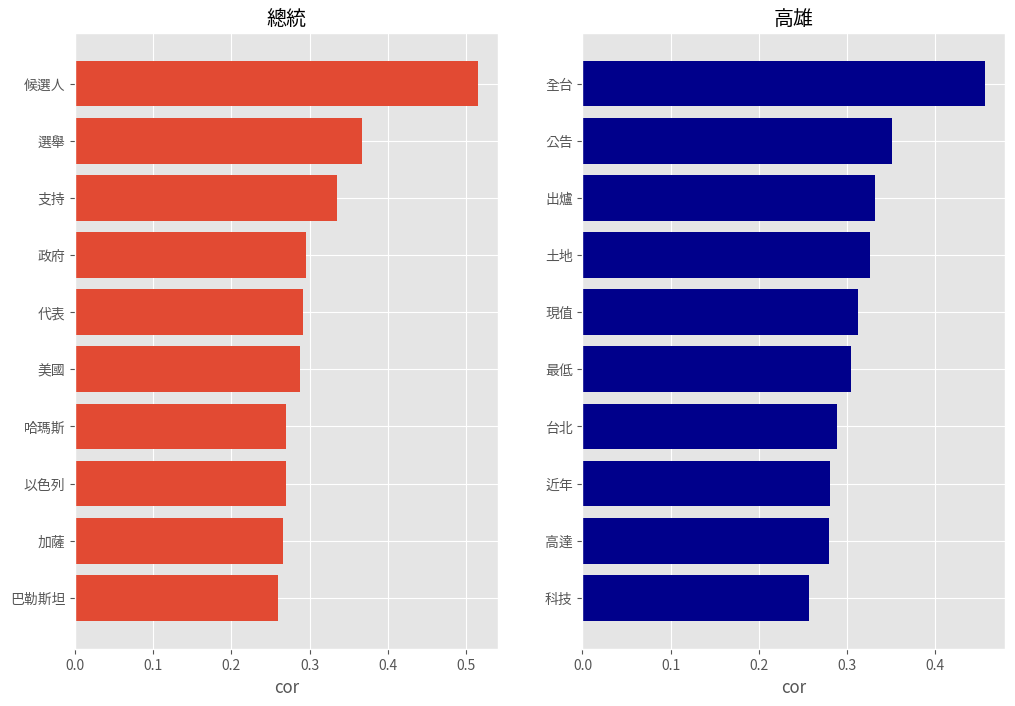

In [46]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('總統')
plt.xlabel('cor')
plt.barh(p['word2'],p['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('高雄')
plt.xlabel('cor')
plt.barh(k['word2'],k['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

本資料集選擇的時間是總統大選前一個月，可以發現和總統相關的關鍵字有**候選人、選舉、支持**等。  
和高雄相關的關鍵字則是有**全台、公告、出爐、土地**等。

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.35的組合

In [47]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [48]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.35的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.35]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,時間,以色列,0.464866
1,美國,以色列,0.477988
2,發展,企業,0.372297
3,市場,全球,0.455690
4,影響,全球,0.354723
...,...,...,...
67,成長,需求,0.360371
68,市場,預期,0.464019
69,成長,預期,0.352039
70,明年,預期,0.406173


In [49]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

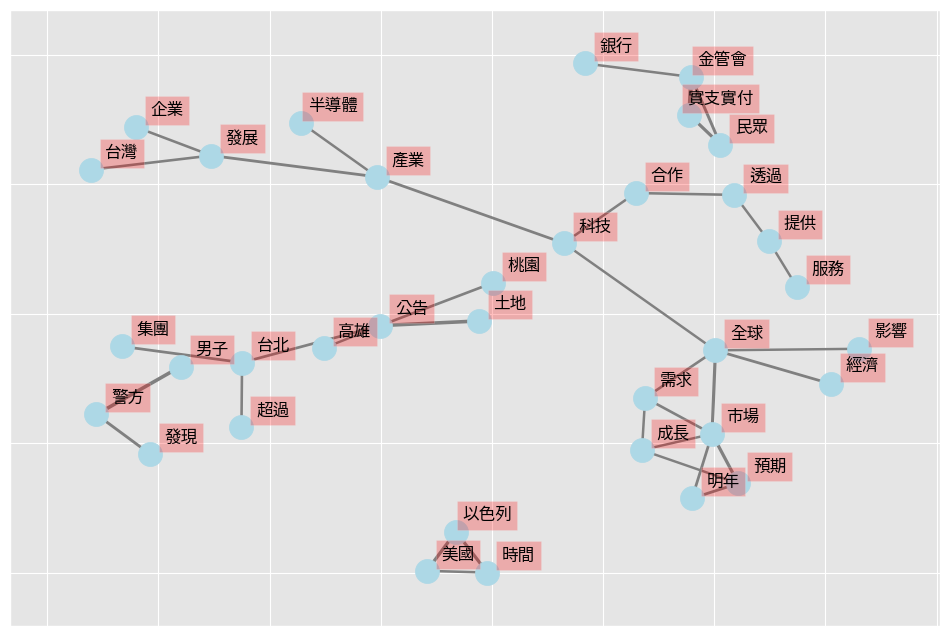

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

詞頻前60為節點且相關性高於0.35的組合中，包含了 **以巴戰爭、房地產地價、台灣科技產業** 等相關主題的詞彙。

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [51]:
data_cos = data_cor.copy()
data_cos.head(3)

,Unnamed: 0,system_id,artTitle,artDate,artCatagory,artUrl,artContent,sentence,word
0,0,1,波蘭新外長籲西方挺烏 基輔盼迅速解除邊界封鎖,2023-12-23 12:12:00,全球,https://udn.com/news/story/122663/7660679,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭，選擇這個飽受戰爭蹂躪的國家作為他外訪的第...,波蘭新任外交部長席科斯基今天敦促西方團結力挺烏克蘭選擇這個飽受戰爭蹂躪的國家作為他外訪的第一...,波蘭 新任 外交部長 科斯 敦促 西方 團結 力挺 烏克蘭 選擇 飽受 戰爭 蹂躪 國家 外...
1,1,2,美國加強施壓俄羅斯 拜登簽署行政命令鎖定金融機構,2023-12-23 15:25:00,全球,https://udn.com/news/story/122663/7661029,美國白宮在聲明中表示，總統拜登今天簽署行政命令，將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁，...,美國白宮在聲明中表示總統拜登今天簽署行政命令將對支持俄羅斯攻打烏克蘭的外國銀行祭出制裁協助俄...,美國白宮 聲明 總統 拜登 簽署 行政命令 將對 支持 俄羅斯 攻打 烏克蘭 外國 銀行 制...
2,2,3,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,2023-12-23 17:49:00,全球,https://udn.com/news/story/122663/7661229,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）和軍方官員表示，烏軍今天在南部前...,烏克蘭總統澤倫斯基和軍方官員表示烏軍今天在南部前線擊落架俄羅斯蘇愷戰鬥轟炸機並稱讚這是俄烏交...,烏克蘭 總統 倫斯基 軍方 官員 南部 前線 擊落 俄羅斯 蘇愷 轟炸機 稱讚 這是 交戰 ...


In [52]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一名,一年,三峽,上市,上漲,下跌,中國,中心,事件,交易,...,電子,需求,預估,預期,預計,顯示,風險,高達,高雄,龍頭
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.129678,0.0,0.000000,0.059143,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.060441,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.101439,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.101789,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.137967,0.062328,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.057295,0.0,0.0,0.065975,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8797,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
8798,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
8799,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
8800,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


計算文章間的cosine similarity

In [53]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第三篇文章相似的文章 : 俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功	

In [54]:
cos_df = pd.DataFrame(cosine_matrix[2], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,0.777662
1,0.471359
2,1.000000
3,0.628263
4,0.527439
...,...
8797,0.000000
8798,0.000000
8799,0.000000
8800,0.000000


In [55]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
2,1.000000,俄烏交戰來一大戰果！烏克蘭稱擊落俄軍3架蘇愷34 專家：愛國者飛彈建功,https://udn.com/news/story/122663/7661229
21,0.936760,俄烏戰火持續 烏克蘭擬下修徵兵年齡,https://udn.com/news/story/122663/7667686
11,0.926128,烏克蘭首迎12月25日耶誕節 俄出動無人機「送禮」、烏軍擊落28架,https://udn.com/news/story/122663/7664854
6,0.913315,俄羅斯再發動無人機攻勢 烏克蘭軍方：擊落14架,https://udn.com/news/story/122663/7662451
13,0.871860,烏克蘭首次在12月25日慶祝聖誕節,https://udn.com/news/story/122663/7665300
58,0.865261,烏克蘭遭受自戰爭爆發以來最嚴重空襲,https://udn.com/news/story/122663/7676777
25,0.863935,烏軍兩樣情 海戰擊中俄大型戰艦 陸戰卻在烏東大撤退,https://udn.com/news/story/122663/7668958
44,0.863789,開戰以來最大空襲之一！俄軍轟炸烏克蘭 釀至少12死逾70傷,https://udn.com/news/story/122663/7674815
43,0.856767,「幾乎動用所有武器」烏遇近期最大空襲 澤倫斯基：俄射逾百枚飛彈,https://udn.com/news/story/122663/7674695
53,0.853863,俄羅斯「動用158種武器」轟炸烏克蘭！至少31死、160人傷,https://udn.com/news/story/122663/7675493


找出的文章主題都是和**俄烏戰爭**相關。

## 7. 建立Ngram預測模型

In [56]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [57]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

### 以Bigram預測下一個出現的詞

因為本資料集的時間是總統大選前一個月，故以"總統大選"相關詞彙作為預測。

In [58]:
bi_prediction = ngram(sen_tokens, N=2)

In [59]:
text = '總統'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 候選人, probability: 0.192
next word: 總統, probability: 0.0948
next word: 選舉罷免, probability: 0.0675
next word: 拜登, probability: 0.0636
next word: 川普, probability: 0.0468


In [60]:
text = '賴清德'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 全國, probability: 0.165
next word: 競選, probability: 0.153
next word: 出面, probability: 0.153
next word: 突襲, probability: 0.0353
next word: 中華, probability: 0.0353


In [61]:
text = '侯友宜'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 競辦, probability: 0.082
next word: 競選, probability: 0.0656
next word: 家人, probability: 0.0492
next word: 臉書, probability: 0.0328
next word: 選舉, probability: 0.0328


In [63]:
text = '柯文哲'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

KeyError: '柯文哲'

奇特的是，**柯文哲**相關詞彙無法預測。